In [2]:
# === importing dependencies ===#
import numpy as np
import xarray as xr
import pandas as pd
import os
import sys
import ast
import yaml

import matplotlib.pyplot as plt

from pytorch_tabnet.tab_model import TabNetRegressor
import pickle
from pickle import dump, load
import joblib

import torch

from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing

#For reproducibility of the results, the following seeds should be selected 
from numpy.random import seed
randSeed = np.random.randint(1000)

root_dir = '/media/harish/SSD/DL_based_wind_profile_estimation'
sys.path.append(root_dir)
from libraries import *
from plotters import *

# === gather variables provided as input arguments ===
config_file = 'config_ERA5.yaml'

# === load yaml file and extract variables ===
with open(config_file, 'r') as yaml_file:
    config = yaml.safe_load(yaml_file)
input_file = config['input_file']
input_times_freq = config['input_times_freq']
Coeff_file = config['Coeff_file']
input_variables = config['input_variables']
train_locations = config['train_locations']
test_dates_range = config['test_dates_range']
test_locations = config['test_locations']
nEns = config['nEns']
tabnet_param_file = config['tabnet_param_file']
target_variables = config['target_variables']

In [3]:
coeff = xr.open_dataset(Coeff_file)
ERA5 = xr.open_dataset(input_file)
CERRA = xr.open_dataset(f'{root_dir}/data/CERRA.nc')
times = coeff.time.values
times

array(['2017-03-23T12:00:00.000000000', '2017-03-23T13:00:00.000000000',
       '2017-03-23T14:00:00.000000000', ...,
       '2018-04-11T14:00:00.000000000', '2018-04-11T15:00:00.000000000',
       '2018-04-11T23:00:00.000000000'], dtype='datetime64[ns]')

In [4]:
# === exclude the nan rows from times ===
nan_rows = np.isnan(coeff['data'].values).any(axis=1)
times = times[~nan_rows]

# profle: best fit date, worst fit date
profile_dates = {'High shear': ['2017-10-17T02:00:00','2017-06-06T10:00:00'],
                'Low shear/well mixed':['2017-05-31T11:00:00','2017-11-20T13:00:00'],
                'LLJ': ['2018-04-10T02:00:00','2017-03-30T02:00:00'],
                'High wind': ['2017-12-31T11:00:00','2018-01-05T04:00:00'],
                }
# get the dates into one list
profile_dates_list = []
for key in profile_dates.keys():
    profile_dates_list.append(profile_dates[key][0])
    profile_dates_list.append(profile_dates[key][1])

# convert dates into datetime64[ns]
profile_dates_list = np.array(profile_dates_list, dtype='datetime64[ns]')

# exclude dates from times
times = np.array([time for time in times if time not in profile_dates_list])

# Randomly divide times into training, validation, and testing by 70%, 20%, and 10%
np.random.seed(randSeed)
np.random.shuffle(times)
train_times = times[:int(0.7*len(times))]
valid_times = times[int(0.7*len(times)):int(0.9*len(times))]
test_times = times[int(0.9*len(times)):]
# add the profile_dates_list to test_times
test_times = np.concatenate([test_times, profile_dates_list])

In [5]:
X_train,Y_train = data_processing_Heligoland(input_file,Coeff_file,input_variables,target_variables,train_times,train_locations)
X_valid,Y_valid = data_processing_Heligoland(input_file,Coeff_file,input_variables,target_variables,valid_times,train_locations)
X_test,Y_test = data_processing_Heligoland(input_file,Coeff_file,input_variables,target_variables,test_times,train_locations)
print('Training inputs shape:',X_train.shape,'training targets shape:',Y_train.shape)
print('Validation inputs shape:',X_valid.shape,'validation targets shape:',Y_valid.shape)
print('Testing inputs shape:',X_test.shape,'testing targets shape:',Y_test.shape)

Training inputs shape: (4912, 24) training targets shape: (4912, 5)
Validation inputs shape: (1404, 24) validation targets shape: (1404, 5)
Testing inputs shape: (710, 24) testing targets shape: (710, 5)


In [6]:
text_locs = [[0.6, 0.95],[0.6, 0.95],[0.6, 0.95],[0.05, 0.95],[0.05, 0.95],[0.6, 0.95]]
df_Obs = pd.read_csv(f'{root_dir}/data/Heligoland_wind.csv',index_col=0,parse_dates=True)
print(df_Obs.head())
# Resampling the data to hourly frequency, by averaging the values
#df_Obs = df_Obs.resample('H').mean() #['Obs_wind_speed']['ws_50_m']

                     ws_40_m  ws_50_m  ws_60_m  ws_70_m  ws_80_m  ws_90_m  \
2017-03-23 12:10:00     8.67     9.19     9.68    10.19    10.63    10.93   
2017-03-23 12:20:00     8.21     8.77     9.24     9.67    10.13    10.45   
2017-03-23 12:30:00     7.59     8.05     8.63     9.11     9.58    10.03   
2017-03-23 12:40:00     7.71     7.96     8.34     8.83     9.43    10.01   
2017-03-23 12:50:00     7.94     8.55     9.22     9.82    10.35    10.78   

                     ws_100_m  ws_120_m  ws_140_m  ws_160_m  ...  ws_260_m  \
2017-03-23 12:10:00     11.11     10.99     10.60     10.22  ...     10.26   
2017-03-23 12:20:00     10.69     10.92     10.91     10.72  ...     10.76   
2017-03-23 12:30:00     10.41     10.73     10.69     10.64  ...     11.28   
2017-03-23 12:40:00     10.53     11.06     11.10     11.06  ...     11.36   
2017-03-23 12:50:00     11.15     11.64     11.67     11.66  ...     11.45   

                     ws_280_m  ws_300_m  ws_320_m  ws_340_m  ws_360_

TabNetRegressor(n_d=8, n_a=8, n_steps=3, gamma=1.4, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=1, n_shared=1, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=600, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=24, output_dim=5, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])
epoch 0  | loss: 0.00705 | train_rmse: 0.0664  | valid_rmse: 0.06644 |  0:00:00s
epoch 1  | loss: 0.00423 | train_rmse: 0.06225 | valid_rmse: 0.06215 |  0:00:01s
epoch 2  | loss: 0.00402 | train_rmse: 0.06156 | valid_rmse: 0.06126 |  0:00:02s
epoch 3  | loss: 0.00396 | train_rmse: 0.06116 | valid_rmse: 0.06083 |  0:00:03s
epoch 4  | loss: 0.00392 | train_rmse: 0.06106 | valid_rmse: 0.06091 |  0:00:03s
epoch 5  | loss: 0.00392 | train_rmse: 0.06074 | valid_rmse: 0.06056 |  0:00:04s
epoch 6  | loss: 0.00389 | train_rmse: 0.06067 | valid_rm

/home/harish/.conda/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNetRegressor(n_d=8, n_a=8, n_steps=5, gamma=1.2, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=3, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=902, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=24, output_dim=5, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])
epoch 0  | loss: 0.00573 | train_rmse: 0.06558 | valid_rmse: 0.06605 |  0:00:01s
epoch 1  | loss: 0.0042  | train_rmse: 0.06333 | valid_rmse: 0.06354 |  0:00:02s
epoch 2  | loss: 0.00401 | train_rmse: 0.06175 | valid_rmse: 0.06203 |  0:00:03s
epoch 3  | loss: 0.0039  | train_rmse: 0.06113 | valid_rmse: 0.06148 |  0:00:04s
epoch 4  | loss: 0.0038  | train_rmse: 0.06042 | valid_rmse: 0.06065 |  0:00:05s
epoch 5  | loss: 0.00382 | train_rmse: 0.06024 | valid_rmse: 0.06047 |  0:00:07s
epoch 6  | loss: 0.00379 | train_rmse: 0.06046 | valid_rm

/home/harish/.conda/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


dumped
TabNetRegressor(n_d=16, n_a=16, n_steps=4, gamma=1.1, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=4, n_shared=3, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=46, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=24, output_dim=5, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])
epoch 0  | loss: 0.00646 | train_rmse: 0.06651 | valid_rmse: 0.06678 |  0:00:01s
epoch 1  | loss: 0.00417 | train_rmse: 0.06283 | valid_rmse: 0.06292 |  0:00:02s
epoch 2  | loss: 0.00392 | train_rmse: 0.06088 | valid_rmse: 0.06094 |  0:00:03s
epoch 3  | loss: 0.00383 | train_rmse: 0.06072 | valid_rmse: 0.06093 |  0:00:04s
epoch 4  | loss: 0.00377 | train_rmse: 0.06035 | valid_rmse: 0.06071 |  0:00:05s
epoch 5  | loss: 0.00378 | train_rmse: 0.05984 | valid_rmse: 0.06    |  0:00:06s
epoch 6  | loss: 0.00371 | train_rmse: 0.05962 | 

/home/harish/.conda/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


dumped
TabNetRegressor(n_d=16, n_a=16, n_steps=4, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=3, n_shared=3, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=337, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=24, output_dim=5, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])
epoch 0  | loss: 0.00619 | train_rmse: 0.06837 | valid_rmse: 0.06784 |  0:00:01s
epoch 1  | loss: 0.00406 | train_rmse: 0.06302 | valid_rmse: 0.06313 |  0:00:02s
epoch 2  | loss: 0.00385 | train_rmse: 0.06341 | valid_rmse: 0.06356 |  0:00:03s
epoch 3  | loss: 0.00377 | train_rmse: 0.06114 | valid_rmse: 0.06164 |  0:00:04s
epoch 4  | loss: 0.0037  | train_rmse: 0.06032 | valid_rmse: 0.06044 |  0:00:05s
epoch 5  | loss: 0.00364 | train_rmse: 0.05897 | valid_rmse: 0.0594  |  0:00:06s
epoch 6  | loss: 0.0036  | train_rmse: 0.059   |

/home/harish/.conda/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


dumped
TabNetRegressor(n_d=8, n_a=8, n_steps=3, gamma=1.1, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=3, n_shared=5, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=492, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=24, output_dim=5, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])
epoch 0  | loss: 0.00782 | train_rmse: 0.0671  | valid_rmse: 0.06609 |  0:00:01s
epoch 1  | loss: 0.00423 | train_rmse: 0.06282 | valid_rmse: 0.06206 |  0:00:02s
epoch 2  | loss: 0.00402 | train_rmse: 0.06186 | valid_rmse: 0.06106 |  0:00:03s
epoch 3  | loss: 0.00389 | train_rmse: 0.06149 | valid_rmse: 0.06085 |  0:00:04s
epoch 4  | loss: 0.00388 | train_rmse: 0.0612  | valid_rmse: 0.06072 |  0:00:05s
epoch 5  | loss: 0.00386 | train_rmse: 0.06108 | valid_rmse: 0.06068 |  0:00:06s
epoch 6  | loss: 0.00385 | train_rmse: 0.06088 | v

/home/harish/.conda/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


dumped
TabNetRegressor(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=5, n_shared=1, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=356, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=24, output_dim=5, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])
epoch 0  | loss: 0.00595 | train_rmse: 0.0678  | valid_rmse: 0.06725 |  0:00:01s
epoch 1  | loss: 0.00437 | train_rmse: 0.06426 | valid_rmse: 0.06279 |  0:00:02s
epoch 2  | loss: 0.00415 | train_rmse: 0.06272 | valid_rmse: 0.06163 |  0:00:03s
epoch 3  | loss: 0.00411 | train_rmse: 0.06299 | valid_rmse: 0.06171 |  0:00:04s
epoch 4  | loss: 0.00413 | train_rmse: 0.06297 | valid_rmse: 0.06195 |  0:00:05s
epoch 5  | loss: 0.0041  | train_rmse: 0.0625  | valid_rmse: 0.06152 |  0:00:06s
epoch 6  | loss: 0.00401 | train_rmse: 0.06219 | v

/home/harish/.conda/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


dumped
TabNetRegressor(n_d=8, n_a=8, n_steps=5, gamma=1.1, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=4, n_shared=4, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=572, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=24, output_dim=5, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])
epoch 0  | loss: 0.00608 | train_rmse: 0.06403 | valid_rmse: 0.06408 |  0:00:01s
epoch 1  | loss: 0.00397 | train_rmse: 0.06222 | valid_rmse: 0.06174 |  0:00:02s
epoch 2  | loss: 0.00383 | train_rmse: 0.06102 | valid_rmse: 0.0608  |  0:00:04s
epoch 3  | loss: 0.00374 | train_rmse: 0.06041 | valid_rmse: 0.06024 |  0:00:05s
epoch 4  | loss: 0.00377 | train_rmse: 0.06013 | valid_rmse: 0.05991 |  0:00:07s
epoch 5  | loss: 0.00374 | train_rmse: 0.05989 | valid_rmse: 0.05955 |  0:00:08s
epoch 6  | loss: 0.00371 | train_rmse: 0.05982 | v

/home/harish/.conda/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


dumped
TabNetRegressor(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=1, n_shared=3, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=564, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=24, output_dim=5, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])
epoch 0  | loss: 0.00753 | train_rmse: 0.06584 | valid_rmse: 0.06554 |  0:00:00s
epoch 1  | loss: 0.00431 | train_rmse: 0.06341 | valid_rmse: 0.06334 |  0:00:01s
epoch 2  | loss: 0.00401 | train_rmse: 0.06267 | valid_rmse: 0.06253 |  0:00:02s
epoch 3  | loss: 0.00394 | train_rmse: 0.06262 | valid_rmse: 0.06254 |  0:00:03s
epoch 4  | loss: 0.00391 | train_rmse: 0.06199 | valid_rmse: 0.06188 |  0:00:04s
epoch 5  | loss: 0.00385 | train_rmse: 0.061   | valid_rmse: 0.06086 |  0:00:05s
epoch 6  | loss: 0.00384 | train_rmse: 0.06113 | v

/home/harish/.conda/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNetRegressor(n_d=16, n_a=16, n_steps=5, gamma=1.1, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=5, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=688, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=24, output_dim=5, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])
epoch 0  | loss: 0.00661 | train_rmse: 0.06561 | valid_rmse: 0.0659  |  0:00:01s
epoch 1  | loss: 0.0042  | train_rmse: 0.0632  | valid_rmse: 0.0632  |  0:00:02s
epoch 2  | loss: 0.00399 | train_rmse: 0.06204 | valid_rmse: 0.06221 |  0:00:03s
epoch 3  | loss: 0.00395 | train_rmse: 0.06244 | valid_rmse: 0.06271 |  0:00:05s
epoch 4  | loss: 0.00388 | train_rmse: 0.0618  | valid_rmse: 0.06186 |  0:00:06s
epoch 5  | loss: 0.0039  | train_rmse: 0.06406 | valid_rmse: 0.06471 |  0:00:07s
epoch 6  | loss: 0.00383 | train_rmse: 0.06544 | valid_

/home/harish/.conda/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


dumped
TabNetRegressor(n_d=16, n_a=16, n_steps=5, gamma=1.2, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=5, n_shared=1, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=52, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=24, output_dim=5, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])
epoch 0  | loss: 0.00629 | train_rmse: 0.06381 | valid_rmse: 0.06411 |  0:00:01s
epoch 1  | loss: 0.00411 | train_rmse: 0.06232 | valid_rmse: 0.06211 |  0:00:02s
epoch 2  | loss: 0.00397 | train_rmse: 0.06314 | valid_rmse: 0.06277 |  0:00:03s
epoch 3  | loss: 0.00388 | train_rmse: 0.063   | valid_rmse: 0.0629  |  0:00:04s
epoch 4  | loss: 0.00386 | train_rmse: 0.06251 | valid_rmse: 0.06247 |  0:00:06s
epoch 5  | loss: 0.00381 | train_rmse: 0.06177 | valid_rmse: 0.06176 |  0:00:07s
epoch 6  | loss: 0.00385 | train_rmse: 0.06073 | 

/home/harish/.conda/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


dumped


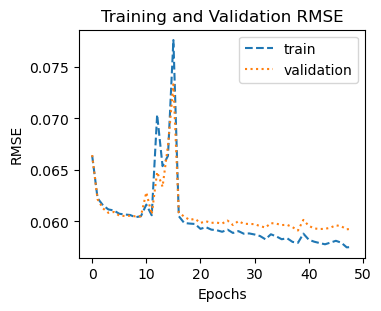

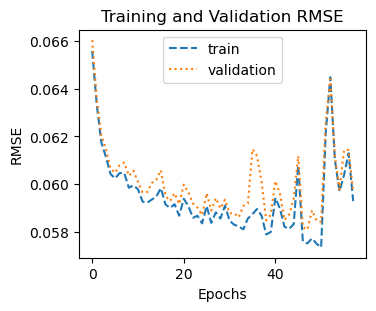

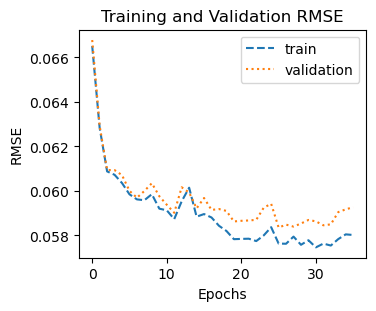

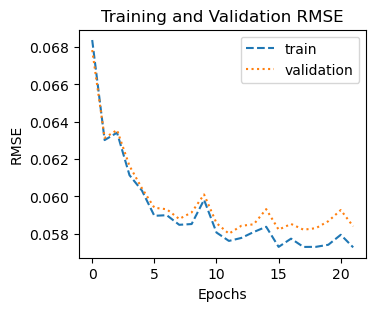

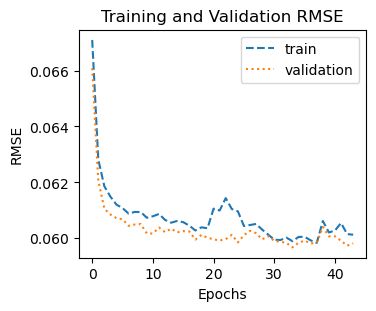

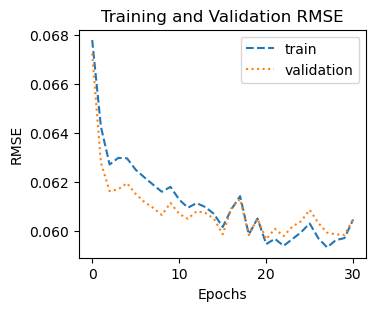

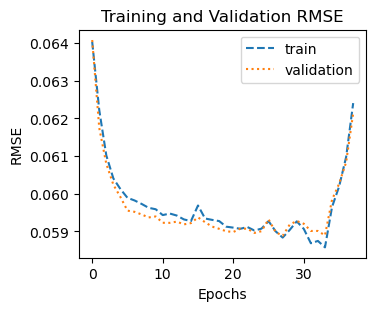

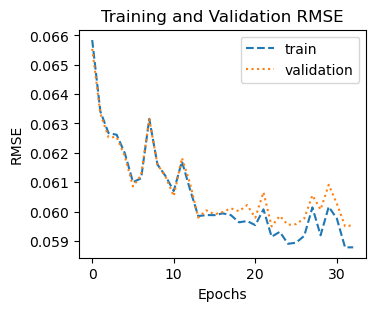

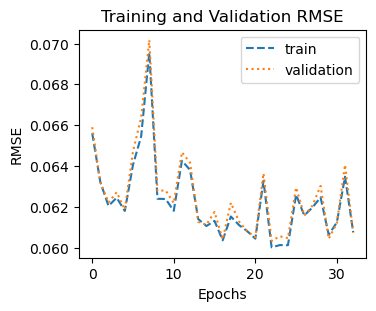

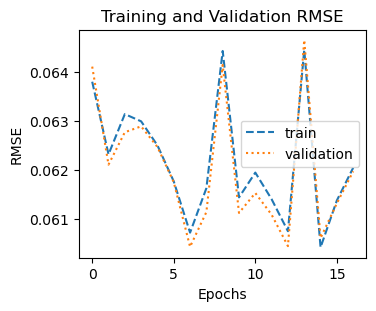

In [8]:
pretrained_experiment = '17Y'
experiment = 'Heligoland_retraining'
pretrained_run = 0
run = 0
for Ens in range(nEns):
    pretrained_OUTPUT_DIR = f'{root_dir}/WES/trained_models/{pretrained_experiment}/run_{pretrained_run}/Ens_{Ens}'
    OUTPUT_DIR = f'{root_dir}/WES/trained_models/{experiment}/run_{run}/Ens_{Ens}'
    os.system(f'mkdir -p {OUTPUT_DIR}')
    # Load model
    fSTR = f'TabNet_HOLDOUT_Ens_{str(Ens)}.pkl'
    with open(f'{pretrained_OUTPUT_DIR}/{fSTR}', "rb") as f:
        tabReg = pickle.load(f)
        print(tabReg)
        
    tabReg.optimizer_params['lr'] = 0.005
    min_max_scaler = preprocessing.MinMaxScaler().fit(Y_train)
    # --- save the normalizing function ---#
    joblib.dump(min_max_scaler, f'{OUTPUT_DIR}/min_max_scaler.joblib')
    Y_train_trans = min_max_scaler.transform(Y_train)
    Y_valid_trans = min_max_scaler.transform(Y_valid)

    tabReg.fit(X_train=X_train, y_train=Y_train_trans,
                        eval_set=[(X_train, Y_train_trans), (X_valid, Y_valid_trans)],
                        eval_name=['train', 'valid'],
                        max_epochs=250, batch_size=256,    #bSize_opt.item(), 
                        eval_metric=['rmse'], patience=10,  #mae, rmse
                        loss_fn = torch.nn.MSELoss(),
                        warm_start=True,) # the warm_start = True is the key to continue training
    
    # Save model
    with open(f'{OUTPUT_DIR}/{fSTR}', "wb") as f:
        dump(tabReg, f, pickle.HIGHEST_PROTOCOL)
    print('dumped')

    # --- Plot loss curve and hexbin ---
    fig = plt.figure(figsize=(18, 3), constrained_layout=True)
    gs = fig.add_gridspec(1,6)

    # Line plot for train and validation RMSE
    ax = fig.add_subplot(gs[0])
    ax.plot(tabReg.history['train_rmse'],'--', label='train')
    ax.plot(tabReg.history['valid_rmse'],':', label='validation')
    ax.set_title('Training and Validation RMSE')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('RMSE')
    ax.legend()

In [9]:
obs_levels = np.array([40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 450, 500])
CERRA_levels = np.array([10., 15., 30., 50., 75., 100., 150., 200., 250., 300., 400., 500.])
ERA5_levels = [10, 100]
def profle_plotter(fig,gs,X_test,Y_test,Obs=None,date=None,title=None,xlabel=None,ylabel=None):
    axs = fig.add_subplot(gs)
    
    # plot ERA5 10m and 100m wind speeds
    ERA5_ws = X_test[0,0:2]
    axs.plot(ERA5_ws, ERA5_levels, 'dg', markerfacecolor='g', label='ERA5')

    # Calculate cerra profile
    M_true = WindProfile(Z, Y_test[0,:])
    axs.plot(M_true, Z, '-k', linewidth=2, markerfacecolor='r', label='CERRA')

    if Obs is not None:
        axs.plot(Obs,obs_levels, '--r', linewidth=2, markerfacecolor='r',label='Obs')

    # Initialize arrays to store ensemble predictions
    ensemble_predictions = np.zeros((10, len(Z)))

    for j, Ens in enumerate(np.arange(10)):
        OUTPUT_DIR = f'{root_dir}/WES/trained_models/{experiment}/run_{run}/Ens_{Ens}'

        # Load normalizer
        min_max_scaler = joblib.load(f'{OUTPUT_DIR}/min_max_scaler.joblib')

        # Load model
        fSTR = f'TabNet_HOLDOUT_Ens_{str(Ens)}.pkl'
        with open(f'{OUTPUT_DIR}/{fSTR}', "rb") as f:
            tabReg = pickle.load(f)
            Y_pred = min_max_scaler.inverse_transform(tabReg.predict(X_test))
        Mp = WindProfile(Z, Y_pred[0, :])
        # Store ensemble predictions
        ensemble_predictions[j, :] = Mp

    # Calculate percentiles
    median_profile = np.median(ensemble_predictions, axis=0)
    p25_profile = np.percentile(ensemble_predictions, 25, axis=0)
    p75_profile = np.percentile(ensemble_predictions, 75, axis=0)
    #p5_profile = np.percentile(ensemble_predictions, 10, axis=0)
    #p95_profile = np.percentile(ensemble_predictions, 90, axis=0)

    # Plot median
    axs.plot(median_profile, Z, linestyle='-', linewidth=2, label='Ensemble (p50)')

    # Plot shaded regions
    axs.fill_betweenx(Z, p25_profile, p75_profile, color='gray', alpha=0.5, label='Ensemble (p25-p75)')
    #axs.fill_betweenx(Z, p5_profile, p95_profile, color='gray', alpha=0.3, label='Ensemble (p10-p90)')

    axs.set_xlim([0, 30])
    axs.set_ylim([0, 500])

    if title is not None:
        axs.set_title(title)

    if xlabel is not None:
        axs.set_xlabel(xlabel)
    if not xlabel:
        axs.xaxis.set_ticks([])
    
    if ylabel is not None:
        axs.set_ylabel(ylabel)
    if not ylabel:
        axs.yaxis.set_ticks([])
    
    return axs

0 High shear 2017-10-17T02:00:00
0 Low shear/well mixed 2017-05-31T11:00:00
0 LLJ 2018-04-10T02:00:00
0 High wind 2017-12-31T11:00:00


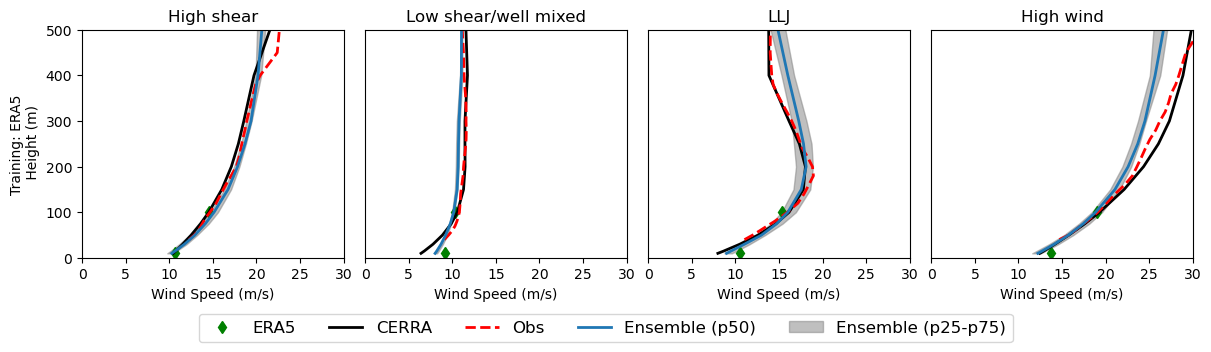

In [10]:
# best profiles
fig = plt.figure(figsize=(12, 3), constrained_layout=True)
gs = fig.add_gridspec(1,4)
i = 0
for k,profile in enumerate(profile_dates):
    print(i,profile, profile_dates[profile][0])

    X_test,Y_test = data_processing_Heligoland(input_file,Coeff_file,input_variables,target_variables,
                                    [profile_dates[profile][0],profile_dates[profile][0]],test_locations)
    Obs = df_Obs[profile_dates[profile][0]:profile_dates[profile][0]].values.T

    title = profile #if i == 0 else None
    xlabel = f'Wind Speed (m/s)' #if i == 4 else None
    ylabel = f'Training: ERA5\n Height (m)' if k == 0 else None
    axs = profle_plotter(fig,gs[i,k],X_test,Y_test,Obs=Obs,title=title,xlabel=xlabel,ylabel=ylabel)

# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.15),fontsize=12)

0 High shear 2017-06-06T10:00:00
0 Low shear/well mixed 2017-11-20T13:00:00
0 LLJ 2017-03-30T02:00:00
0 High wind 2018-01-05T04:00:00


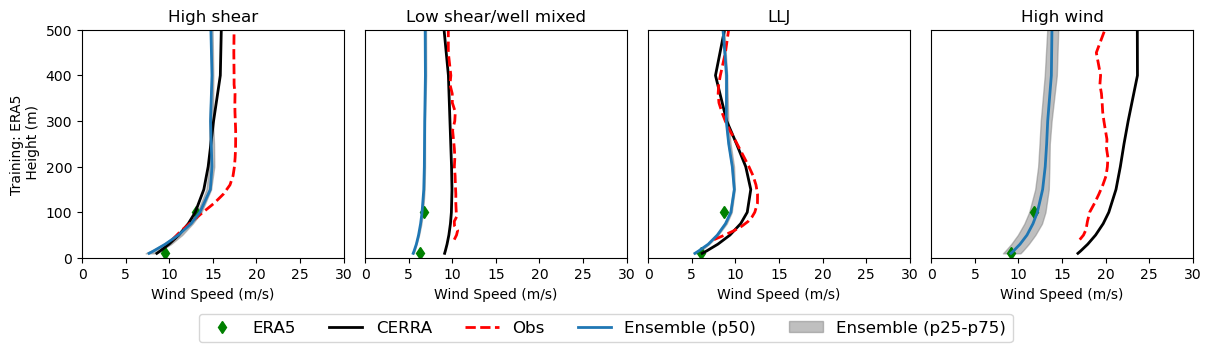

In [11]:
# worst profiles
fig = plt.figure(figsize=(12, 3), constrained_layout=True)
gs = fig.add_gridspec(1,4)
i = 0
for k,profile in enumerate(profile_dates):
    print(i,profile, profile_dates[profile][1])

    X_test,Y_test = data_processing_Heligoland(input_file,Coeff_file,input_variables,target_variables,
                                    [profile_dates[profile][1],profile_dates[profile][1]],test_locations)
    X_test,Y_test = data_processing(input_file,f'{root_dir}/data/Chebyshev_Coefficnents.nc',input_times_freq,input_variables,target_variables,
                                        [profile_dates[profile][1],profile_dates[profile][1]],test_locations)
    Obs = df_Obs[profile_dates[profile][1]:profile_dates[profile][1]].values.T

    title = profile #if i == 0 else None
    xlabel = f'Wind Speed (m/s)' #if i == 4 else None
    ylabel = f'Training: ERA5\n Height (m)' if k == 0 else None
    axs = profle_plotter(fig,gs[i,k],X_test,Y_test,Obs=Obs,title=title,xlabel=xlabel,ylabel=ylabel)

# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.15),fontsize=12)